In [1]:
import pandas as pd
import numpy as np
import random
import os
import sys
import matplotlib.pyplot as plt
import math

## Get forecasts from CSV files

In [2]:
df_final = pd.DataFrame(list(range(17)), columns=['hours_in_future'])

# Iterate over all files in the directory
for file_name in sorted(os.listdir(os.getcwd()+'/forecasts')):
        
    df = pd.read_csv(os.getcwd()+f'/forecasts/{file_name}')
    
    if len(df) != 17: continue

    date, hour = file_name.split('_')[2].split("-")
    df_final[f'forecast_{date[6:8]}-{date[4:6]}-{hour[:2]}'] = list(df.temp_air)
        
df_final = df_final.drop('hours_in_future', axis = 1)
df_final = df_final.dropna(axis=1, how='any')

print(f"\nWe have {len(df_final.columns.to_list())} 16-hour forecasts.\n")
display(df_final)

/var/folders/0x/l1m3sdhn7r59npk394yrpzk40000gn/T/ipykernel_1386/2725665708.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final[f'forecast_{date[6:8]}-{date[4:6]}-{hour[:2]}'] = list(df.temp_air)



We have 4098 16-hour forecasts.



,forecast_19-05-22,forecast_19-05-23,forecast_20-05-00,forecast_20-05-01,forecast_20-05-02,forecast_20-05-03,forecast_20-05-05,forecast_20-05-06,forecast_20-05-07,forecast_20-05-08,...,forecast_03-12-18,forecast_03-12-19,forecast_03-12-20,forecast_04-12-00,forecast_04-12-01,forecast_04-12-02,forecast_04-12-03,forecast_04-12-04,forecast_04-12-05,forecast_04-12-06
0,8.574249,8.087067,7.755402,7.200653,7.143738,6.647675,5.867828,5.754303,7.271820,8.588654,...,8.085480,9.024384,9.257111,8.290436,8.454132,8.576874,8.622223,8.529175,8.377411,8.001038
1,8.101715,7.680145,7.205566,6.944550,6.764191,6.110870,5.565796,7.054840,8.737091,10.183105,...,8.825745,9.013336,9.439117,8.975525,8.794830,8.518188,8.486237,8.378876,8.460419,8.143341
2,7.490875,7.224640,6.954010,6.513031,6.375092,5.918915,6.791351,8.636322,10.205048,12.036468,...,8.994385,9.000671,9.510986,9.188141,8.736023,8.603424,8.428192,8.275604,8.348633,8.572784
3,7.127899,6.891022,6.521301,6.157501,5.961426,5.561157,8.241364,10.264008,12.194305,13.924042,...,9.118073,9.062042,9.327240,9.094635,8.754120,8.661652,8.407288,8.324738,8.488983,8.924469
4,6.887970,6.565460,6.061096,5.765686,5.603241,6.874481,9.790802,12.363617,14.036468,15.222259,...,9.126129,9.385223,9.427979,9.034149,8.772430,8.545166,8.453461,8.492706,8.909210,9.391998
5,6.492493,6.201996,5.638031,5.523102,6.860840,8.200470,11.933380,14.091705,15.192780,16.032684,...,8.936798,9.409271,9.357788,8.946259,8.661804,8.361725,8.529266,8.628845,9.107422,9.771393
6,6.125275,5.833618,5.472809,6.588379,8.249512,9.799469,13.678619,15.085297,15.927124,16.190704,...,9.102631,9.245087,9.246307,8.649872,8.509430,8.080963,8.695557,9.450592,9.553101,11.030243
7,5.781158,5.320740,6.642853,7.968384,9.858307,11.952850,14.790009,15.854492,16.191101,16.016937,...,9.140717,9.144806,9.227875,8.343811,8.481262,8.471100,9.374298,10.201447,10.956940,11.564423
8,5.277741,6.401306,7.977570,9.702789,11.906769,13.738861,15.530731,16.030975,15.817535,15.699738,...,9.145111,9.060425,9.042999,8.197144,8.650848,8.788452,10.241974,10.848389,11.579681,11.889221
9,6.180237,7.889710,9.694916,11.843780,13.696503,14.996429,15.767364,15.792999,15.420776,15.176422,...,9.077423,8.924591,8.956207,8.414581,8.919769,9.428314,11.232636,11.386780,11.905548,11.725739


## Get measurements from btrdb API

In [3]:
import datetime as dtm

# Function to gather data from database
def download_data(dt_start=dtm.datetime(2020,10,6,11,0),
                  dt_final=dtm.datetime.now()):
    
    # Specify specific exterior weather values to download
    channels = ['Exterior_we_Temperature_C']

    # Download data
    res = db.read_raw_db(dt_start, dt_final, channels)
    
    return res

In [4]:
# First and last dates in the data
dates = df_final.columns.to_list()
first_date = '2021-' + dates[0].split("_")[1] + ':00:00'
last_date = '2021-' + dates[-1].split("_")[1] + ':00:00'

# Convert to timestamps
format_string = "%Y-%d-%m-%H:%M:%S"
first_timestamp = dtm.datetime.strptime(first_date, format_string)
last_timestamp = dtm.datetime.strptime(last_date, format_string)
print(f"First timestamp: {first_timestamp}\nLast timestamp: {last_timestamp}")
print(len(dates))

First timestamp: 2021-05-19 22:00:00
Last timestamp: 2021-12-04 06:00:00
4098


In [5]:
'''
# Log into database
sys.path.append(os.getcwd()+'/measurements/btrdb_api')
from client import client as btrdb

db = btrdb()
db.login_no_interactive('device1', '123456')

# Download data
monitored_data = download_data(dt_start = first_timestamp, dt_final = last_timestamp)
monitored_data = monitored_data.rename(columns={'Exterior_we_Temperature_C': 'T_OA'})
monitored_data = monitored_data[['T_OA']]

# Average hourly
measurement_hourly = monitored_data.resample('H').mean()
print(f"Succesfully loaded hourly weather measurements.")
display(measurement_hourly)
'''

'\n# Log into database\nsys.path.append(os.getcwd()+\'/measurements/btrdb_api\')\nfrom client import client as btrdb\n\ndb = btrdb()\ndb.login_no_interactive(\'device1\', \'123456\')\n\n# Download data\nmonitored_data = download_data(dt_start = first_timestamp, dt_final = last_timestamp)\nmonitored_data = monitored_data.rename(columns={\'Exterior_we_Temperature_C\': \'T_OA\'})\nmonitored_data = monitored_data[[\'T_OA\']]\n\n#\xa0Average hourly\nmeasurement_hourly = monitored_data.resample(\'H\').mean()\nprint(f"Succesfully loaded hourly weather measurements.")\ndisplay(measurement_hourly)\n'

In [6]:
measurement_hourly = pd.read_csv(os.getcwd()+'/measurements/flexlab_temp.csv')
measurement_hourly = measurement_hourly.rename(columns={'/weather/Weather-Station/W-OAT-2': 'T_OA'})
print(f"Succesfully loaded hourly weather measurements.")
measurement_hourly['datetime'] = pd.to_datetime(measurement_hourly['datetime'])
measurement_hourly.set_index('datetime', inplace=True)
display(measurement_hourly)

Succesfully loaded hourly weather measurements.


,T_OA
datetime,
2021-05-19 22:00:00,7.475643
2021-05-19 23:00:00,7.246134
2021-05-20 00:00:00,7.146860
2021-05-20 01:00:00,5.813126
2021-05-20 02:00:00,5.515030
...,...
2021-12-04 00:00:00,9.272185
2021-12-04 01:00:00,9.375470
2021-12-04 02:00:00,9.338835


In [7]:
df = df_final
for col in df.columns.to_list():

    # Convert to datetime
    date = '2021-' + col.split("_")[1] + ':00:00'
    format_string = "%Y-%d-%m-%H:%M:%S"
    date = dtm.datetime.strptime(date, format_string)

    # Find all measurements in the next 16 hours at that date
    next_hours = []
    for hour in range(17):
        next_hours.append(date + dtm.timedelta(hours=hour))

    try:
        measurements_next_hours = measurement_hourly.loc[next_hours]
    except:
        print(f"Some of the measurements did not exist for {date}, dropped the column.")
        df = df.drop(col, axis=1)
        df_final = df_final.drop(col, axis=1)
        continue

    #print(date)
    #print(list(measurements_next_hours.T_OA))  
    
    column_name = "measurement_" + col.split("_")[1]
    df[column_name] = list(measurements_next_hours.T_OA)

print("")
display(df)

/var/folders/0x/l1m3sdhn7r59npk394yrpzk40000gn/T/ipykernel_1386/3087825416.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = list(measurements_next_hours.T_OA)


Some of the measurements did not exist for 2021-12-03 13:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-03 14:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-03 16:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-03 17:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-03 18:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-03 19:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-03 20:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-04 00:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-04 01:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-04 02:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-04 03:00:00, dropped the column.
Some of the measurements did not exist for 2021-12-04 04:00:00, dropped the 

,forecast_19-05-22,forecast_19-05-23,forecast_20-05-00,forecast_20-05-01,forecast_20-05-02,forecast_20-05-03,forecast_20-05-05,forecast_20-05-06,forecast_20-05-07,forecast_20-05-08,...,measurement_03-12-01,measurement_03-12-02,measurement_03-12-03,measurement_03-12-04,measurement_03-12-05,measurement_03-12-06,measurement_03-12-07,measurement_03-12-08,measurement_03-12-10,measurement_03-12-11
0,8.574249,8.087067,7.755402,7.200653,7.143738,6.647675,5.867828,5.754303,7.271820,8.588654,...,9.815758,9.668934,9.751688,9.506282,9.503432,9.037522,8.688420,9.128540,9.483669,10.022805
1,8.101715,7.680145,7.205566,6.944550,6.764191,6.110870,5.565796,7.054840,8.737091,10.183105,...,9.668934,9.751688,9.506282,9.503432,9.037522,8.688420,9.128540,9.082436,10.022805,9.943107
2,7.490875,7.224640,6.954010,6.513031,6.375092,5.918915,6.791351,8.636322,10.205048,12.036468,...,9.751688,9.506282,9.503432,9.037522,8.688420,9.128540,9.082436,9.483669,9.943107,9.650901
3,7.127899,6.891022,6.521301,6.157501,5.961426,5.561157,8.241364,10.264008,12.194305,13.924042,...,9.506282,9.503432,9.037522,8.688420,9.128540,9.082436,9.483669,10.022805,9.650901,10.863774
4,6.887970,6.565460,6.061096,5.765686,5.603241,6.874481,9.790802,12.363617,14.036468,15.222259,...,9.503432,9.037522,8.688420,9.128540,9.082436,9.483669,10.022805,9.943107,10.863774,10.952081
5,6.492493,6.201996,5.638031,5.523102,6.860840,8.200470,11.933380,14.091705,15.192780,16.032684,...,9.037522,8.688420,9.128540,9.082436,9.483669,10.022805,9.943107,9.650901,10.952081,10.801434
6,6.125275,5.833618,5.472809,6.588379,8.249512,9.799469,13.678619,15.085297,15.927124,16.190704,...,8.688420,9.128540,9.082436,9.483669,10.022805,9.943107,9.650901,10.863774,10.801434,10.053969
7,5.781158,5.320740,6.642853,7.968384,9.858307,11.952850,14.790009,15.854492,16.191101,16.016937,...,9.128540,9.082436,9.483669,10.022805,9.943107,9.650901,10.863774,10.952081,10.053969,10.115443
8,5.277741,6.401306,7.977570,9.702789,11.906769,13.738861,15.530731,16.030975,15.817535,15.699738,...,9.082436,9.483669,10.022805,9.943107,9.650901,10.863774,10.952081,10.801434,10.115443,9.547341
9,6.180237,7.889710,9.694916,11.843780,13.696503,14.996429,15.767364,15.792999,15.420776,15.176422,...,9.483669,10.022805,9.943107,9.650901,10.863774,10.952081,10.801434,10.053969,9.547341,9.502037


In [8]:
print("The following measurements contained NaNs.\nDropped both the measurement and forecast columns.")

for col in sorted(df.columns.to_list()):

    if df[col].isna().any():

        print(f"{col.split('_')[1]}")

        # Drop both the measurement and the forecast columns
        measurement_col = "measurement_" + col.split("_")[1]
        forecast_col = "forecast_" + col.split("_")[1]
        df = df.drop(measurement_col, axis=1)
        df = df.drop(forecast_col, axis=1)        
        df_final = df_final.drop(measurement_col, axis=1)
        df_final = df_final.drop(forecast_col, axis=1)
        
    else:
        continue

print("-")

The following measurements contained NaNs.
Dropped both the measurement and forecast columns.
-


## Bias correction

In [9]:
# Backup
df_no_bias_correction = df

# Relative error in hour 0, for each forecast
for col in df_final.columns.to_list():

    forecast_col = "forecast_" + col.split("_")[1]
    measurement_col = "measurement_" + col.split("_")[1]

    # Compute relative error at hour 0
    f = df[forecast_col].iloc[0]
    m = df[measurement_col].iloc[0]
    r = (f-m)/f
    
    # print(col)
    # print(f"Relative error of hour 0: {round(r,3)}\n")

    # Apply that relative error at each hour of the forecast
    for k in range(len(df)):
        #print(f"Original forecast: {df[forecast_col].iloc[k]}")
        #print(f"Hour{k} measurement: {df[measurement_col].iloc[k]}")
        #print(f"Adjusted forecast: {df[forecast_col].iloc[k] * (1-r)}\n")
        df[forecast_col].iloc[k] = df[forecast_col].iloc[k] * (1-r)

In [10]:
display(df)

,forecast_19-05-22,forecast_19-05-23,forecast_20-05-00,forecast_20-05-01,forecast_20-05-02,forecast_20-05-03,forecast_20-05-05,forecast_20-05-06,forecast_20-05-07,forecast_20-05-08,...,measurement_03-12-01,measurement_03-12-02,measurement_03-12-03,measurement_03-12-04,measurement_03-12-05,measurement_03-12-06,measurement_03-12-07,measurement_03-12-08,measurement_03-12-10,measurement_03-12-11
0,7.475643,7.246134,7.146860,5.813126,5.515030,6.238434,5.449184,5.975661,8.936033,11.399351,...,9.815758,9.668934,9.751688,9.506282,9.503432,9.037522,8.688420,9.128540,9.483669,10.022805
1,7.063654,6.881526,6.640169,5.606372,5.222016,5.734676,5.168700,7.326228,10.736642,13.515597,...,9.668934,9.751688,9.506282,9.503432,9.037522,8.688420,9.128540,9.082436,10.022805,9.943107
2,6.531080,6.473386,6.408351,5.258005,4.921628,5.554538,6.306817,8.968546,12.540553,15.975487,...,9.751688,9.506282,9.503432,9.037522,8.688420,9.128540,9.082436,9.483669,9.943107,9.650901
3,6.214611,6.174459,6.009596,4.970984,4.602275,5.218804,7.653377,10.658847,14.985067,18.480782,...,9.506282,9.503432,9.037522,8.688420,9.128540,9.082436,9.483669,10.022805,9.650901,10.863774
4,6.005424,5.882751,5.585501,4.654669,4.325753,6.451278,9.092270,12.839224,17.248824,20.203851,...,9.503432,9.037522,8.688420,9.128540,9.082436,9.483669,10.022805,9.943107,10.863774,10.952081
5,5.660619,5.557082,5.195633,4.458830,5.296630,7.695637,11.081984,14.633789,18.669766,21.279492,...,9.037522,8.688420,9.128540,9.082436,9.483669,10.022805,9.943107,9.650901,10.952081,10.801434
6,5.340452,5.227010,5.043375,5.318834,6.368698,9.196199,12.702707,15.665602,19.572170,21.489225,...,8.688420,9.128540,9.082436,9.483669,10.022805,9.943107,9.650901,10.863774,10.801434,10.053969
7,5.040427,4.767463,6.121609,6.432919,7.610702,11.217015,13.734804,16.464387,19.896561,21.258592,...,9.128540,9.082436,9.483669,10.022805,9.943107,9.650901,10.863774,10.952081,10.053969,10.115443
8,4.601511,5.735667,7.351595,7.833114,9.192133,12.893076,14.422679,16.647659,19.437501,20.837587,...,9.082436,9.483669,10.022805,9.943107,9.650901,10.863774,10.952081,10.801434,10.115443,9.547341
9,5.388372,7.069299,8.934187,9.561548,10.573824,14.073227,14.642430,16.400528,18.949941,20.143012,...,9.483669,10.022805,9.943107,9.650901,10.863774,10.952081,10.801434,10.053969,9.547341,9.502037


## Compute confidence intervals

In [11]:
alpha = 0.1
print(f"Computing the {round((1-alpha)*100,1)}% confidence interval")

Computing the 90.0% confidence interval


In [12]:
residuals = {}
n = len(df_final.columns.to_list())

# For every forecasted hour (0 to 16)
for k in range(len(df)):

    count_out = 0

    residuals[f'hour{k}'] = []

    # For all forecasts
    for col in df_final.columns.to_list():

        # Get the corresponding forecast and measurement columns
        forecast_name = "forecast_" + col.split("_")[1]
        measurement_name = "measurement_" + col.split("_")[1]

        # Residual = abs(forecast(k)-measurement(k))
        residual = np.abs(df[measurement_name].iloc[k] - df[forecast_name].iloc[k])
        residuals[f'hour{k}'].append(round(residual,10))

    # Check for NaN values in residuals
    nan_count = sum(math.isnan(x) for x in residuals[f'hour{k}'])
    if nan_count != 0: 
        raise ValueError(f"Found {nan_count} NaN values in the residuals at hour {k}.")

    # Check that the confidence interval makes sense
    sorted_residuals = sorted(residuals[f'hour{k}'])
    idx = int((1-alpha)*(len(sorted_residuals)+1))
    CI = sorted_residuals[idx]
    testing = [1 if x<CI else 0 for x in sorted_residuals]
    if k==0 or round((1-sum(testing)/len(sorted_residuals)),1) <= alpha: 
        print(f"[OK] Hour {k}")
    else:
        print(f"[ERROR] Hour {k}")
        print(round((1-sum(testing)/len(sorted_residuals)),1))
        raise ValueError(f"Error on confidence interval {k}")

[OK] Hour 0
[OK] Hour 1
[OK] Hour 2
[OK] Hour 3
[OK] Hour 4
[OK] Hour 5
[OK] Hour 6
[OK] Hour 7
[OK] Hour 8
[OK] Hour 9
[OK] Hour 10
[OK] Hour 11
[OK] Hour 12
[OK] Hour 13
[OK] Hour 14
[OK] Hour 15
[OK] Hour 16


In [13]:
def confidence_intevals(alpha):

    n = len(df_final.columns.to_list())

    CIs_final = []

    for k in range(len(df)):
    
        sorted_residuals = sorted(residuals[f'hour{k}'])
        CI = sorted_residuals[int((1-alpha)*(n+1))]
    
        CIs_final.append(CI)
    
    return(CIs_final)

CIs = confidence_intevals(alpha)
print(CIs)

[0.0, 2.1701986327, 3.2432317293, 3.8816727817, 4.1927924567, 4.5471149007, 4.8879055085, 5.1601262315, 5.4162326974, 5.6253464746, 5.7726944856, 5.7918617148, 5.7904592269, 5.7871057489, 5.9118727294, 5.8538210257, 5.803292665]


## Plots to illustrate

CI at 90%: [0.0, 2.17, 3.243, 3.882, 4.193, 4.547, 4.888, 5.16, 5.416, 5.625, 5.773, 5.792, 5.79, 5.787, 5.912, 5.854, 5.803]

CI at 95%: [0.0, 2.878, 4.124, 4.781, 5.32, 5.694, 6.089, 6.396, 6.671, 6.843, 7.039, 7.035, 7.075, 7.153, 7.099, 7.079, 6.94]

CI at 99%: [0.0, 4.387, 6.252, 6.878, 7.534, 8.065, 8.645, 9.025, 9.27, 9.604, 9.848, 9.806, 9.693, 9.803, 9.603, 9.555, 9.509]



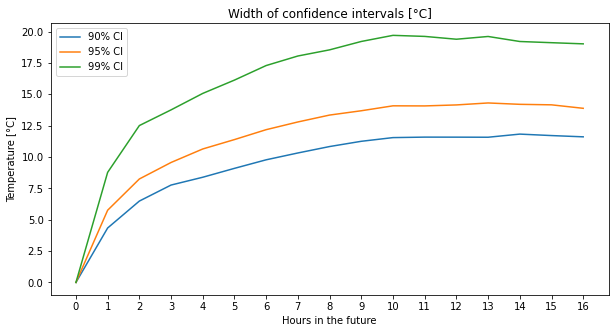

In [14]:
plt.figure(figsize=(10,5))
for a in [0.1, 0.05, 0.01]:
    print(f"CI at {round((1-a)*100)}%: {[round(x,3) for x in confidence_intevals(a)]}\n")
    plt.plot([x*2 for x in confidence_intevals(a)], label=f'{round(100*(1-a))}% CI')
plt.title(f"Width of confidence intervals [°C]")
plt.xlabel("Hours in the future")
plt.ylabel("Temperature [°C]")
plt.xticks(range(len(CIs)))
plt.legend()
plt.show()

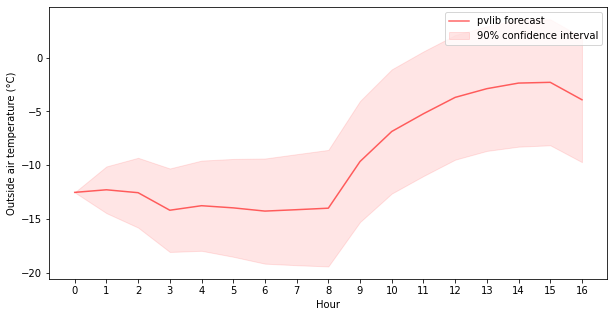

In [15]:
# Get the forecast
T_OA_list = [-12.52, -12.28, -12.55, -14.18, -13.76, -13.96, -14.26, 
             -14.13, -13.99, -9.65, -6.86, -5.21, -3.69, -2.88, -2.36, 
             -2.29, -3.91, -5.52, -6.13, -6.58, -7.09, -7.43, -7.99, -8.68]

# Plot the weather with the confidence interval
lower_bounds = [T_OA_list[i] - CIs[i] for i in range(len(CIs))]
upper_bounds = [T_OA_list[i] + CIs[i] for i in range(len(CIs))]
plt.figure(figsize=(10,5))
plt.plot(T_OA_list[:len(CIs)], color='red', alpha=0.6, label='pvlib forecast')
plt.fill_between(range(len(CIs)), lower_bounds, upper_bounds, color='red', alpha=0.1, 
                 label=f"{round(100*(1-alpha))}% confidence interval")
plt.xlabel("Hour")
plt.ylabel("Outside air temperature (°C)")
plt.xticks(list(range(len(CIs))))
plt.legend()
plt.show()

In [16]:
# Final check
num_outside = [0]*len(df)
num_total = [0]*len(df)

for col in df_final.columns.to_list():
    
    forecast_name = "forecast_" + col.split("_")[1]
    measurement_name = "measurement_" + col.split("_")[1]

    lower_bounds = [df[forecast_name].iloc[i] - CIs[i] for i in range(len(df))]
    upper_bounds = [df[forecast_name].iloc[i] + CIs[i] for i in range(len(df))]

    for i in range(len(df)):
        if df[measurement_name].iloc[i] < lower_bounds[i] or df[measurement_name].iloc[i] > upper_bounds[i]:
            num_outside[i] += 1
        num_total[i] += 1

for i in range(1,len(df)):
    print(f"Hour {i}: {round(100*num_outside[i]/num_total[i],1)}% of the data outisde the {round((1-alpha)*100)}% CI.")

Hour 1: 10.0% of the data outisde the 90% CI.
Hour 2: 10.0% of the data outisde the 90% CI.
Hour 3: 10.0% of the data outisde the 90% CI.
Hour 4: 10.0% of the data outisde the 90% CI.
Hour 5: 10.0% of the data outisde the 90% CI.
Hour 6: 10.0% of the data outisde the 90% CI.
Hour 7: 10.0% of the data outisde the 90% CI.
Hour 8: 10.0% of the data outisde the 90% CI.
Hour 9: 10.0% of the data outisde the 90% CI.
Hour 10: 10.0% of the data outisde the 90% CI.
Hour 11: 10.0% of the data outisde the 90% CI.
Hour 12: 10.0% of the data outisde the 90% CI.
Hour 13: 10.0% of the data outisde the 90% CI.
Hour 14: 10.0% of the data outisde the 90% CI.
Hour 15: 10.0% of the data outisde the 90% CI.
Hour 16: 10.0% of the data outisde the 90% CI.
